In [ ]:
#| default_exp fid

# FID

In [ ]:
#|export
import pickle,gzip,math,os,time,shutil,torch,random
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager
from scipy import linalg

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.accel import *

In [ ]:
from fastcore.test import test_close
from torch import distributions

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'

import logging
logging.disable(logging.WARNING)

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

## Train classifier

In [ ]:
xl,yl = 'image','label'
name = "fashion_mnist"
bs = 512

@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2)) for o in b[xl]]

dsd = load_dataset(name)
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus)

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
b = xb,yb = next(iter(dls.train))

In [ ]:
cbs = [DeviceCB(), MixedPrecision()]
model = torch.load('models/data_aug.pkl')
learn = Learner(model, dls, F.cross_entropy, cbs=cbs, opt_func=opt_func)

In [ ]:
def append_outp(hook, mod, inp, outp):
    if not hasattr(hook,'outp'): hook.outp = []
    hook.outp.append(to_cpu(outp))

In [ ]:
hcb = HooksCallback(append_outp, mods=[learn.model[6]], on_valid=True)

In [ ]:
learn.fit(1, train=False, cbs=[hcb])

In [ ]:
feats = hcb.hooks[0].outp[0].float()[:64]
feats.shape

torch.Size([64, 512])

In [ ]:
del(learn.model[8])
del(learn.model[7])

In [ ]:
feats,y = learn.capture_preds()
feats = feats.float()
feats.shape,y

(torch.Size([10000, 512]), tensor([9, 2, 1,  ..., 8, 1, 5]))

## Calc FID

In [ ]:
betamin,betamax,n_steps = 0.0001,0.02,1000
beta = torch.linspace(betamin, betamax, n_steps)
alpha = 1.-beta
alphabar = alpha.cumprod(dim=0)
sigma = beta.sqrt()

In [ ]:
def noisify(x0, ᾱ):
    device = x0.device
    n = len(x0)
    t = torch.randint(0, n_steps, (n,), dtype=torch.long)
    ε = torch.randn(x0.shape, device=device)
    ᾱ_t = ᾱ[t].reshape(-1, 1, 1, 1).to(device)
    xt = ᾱ_t.sqrt()*x0 + (1-ᾱ_t).sqrt()*ε
    return (xt, t.to(device)), ε

def collate_ddpm(b): return noisify(default_collate(b)[xl], alphabar)
def dl_ddpm(ds): return DataLoader(ds, batch_size=bs, collate_fn=collate_ddpm, num_workers=4)

In [ ]:
dls2 = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))

In [ ]:
from diffusers import UNet2DModel

class UNet(UNet2DModel):
    def forward(self, x): return super().forward(*x).sample

In [ ]:
smodel = torch.load('models/fashion_ddpm_mp.pkl').cuda()

In [ ]:
@torch.no_grad()
def sample(model, sz, alpha, alphabar, sigma, n_steps):
    device = next(model.parameters()).device
    x_t = torch.randn(sz, device=device)
    preds = []
    for t in reversed(range(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=device, dtype=torch.long)
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(device)
        ᾱ_t1 = alphabar[t-1]  if t > 0 else torch.tensor(1)
        b̄_t = 1 - alphabar[t]
        b̄_t1 = 1 - ᾱ_t1
        x_0_hat = ((x_t - b̄_t.sqrt() * model((x_t, t_batch)))/alphabar[t].sqrt()).clamp(-1,1)
        x_t = x_0_hat * ᾱ_t1.sqrt()*(1-alpha[t])/b̄_t + x_t * alpha[t].sqrt()*b̄_t1/b̄_t + sigma[t]*z
        preds.append(x_t.cpu().clamp(0,1))
    return preds

In [ ]:
%%time
samples = sample(smodel, (512, 1, 32, 32), alpha, alphabar, sigma, n_steps)

CPU times: user 35min 41s, sys: 1min 1s, total: 36min 43s
Wall time: 1min 8s


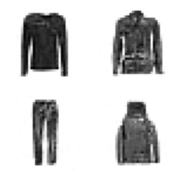

In [ ]:
show_images(samples[-1][:4], imsize=1.5)

In [ ]:
clearn = TrainLearner(model, DataLoaders([],[(samples[-1],b[1])]), loss_func=fc.noop, cbs=[DeviceCB()], opt_func=None)
feats2,y2 = clearn.capture_preds()
feats2 = feats2.float().squeeze()
feats2.shape

torch.Size([512, 512])

In [ ]:
means = feats.mean(0)
means.shape

torch.Size([512])

In [ ]:
covs = feats.T.cov()
covs.shape

torch.Size([512, 512])

In [ ]:
#|export
def _sqrtm_newton_schulz(mat, num_iters=100):
    mat_nrm = mat.norm()
    mat = mat.double()
    Y = mat/mat_nrm
    n = len(mat)
    I = torch.eye(n, n).to(mat)
    Z = torch.eye(n, n).to(mat)

    for i in range(num_iters):
        T = (3*I - Z@Y)/2
        Y,Z = Y@T,T@Z
        res = Y*mat_nrm.sqrt()
        if ((mat-(res@res)).norm()/mat_nrm).abs()<=1e-6: break
    return res

In [ ]:
#|export
def _calc_stats(feats):
    feats = feats.squeeze()
    return feats.mean(0),feats.T.cov()

def _calc_fid(m1,c1,m2,c2):
#     csr = _sqrtm_newton_schulz(c1@c2)
    csr = tensor(linalg.sqrtm(c1@c2, 256).real)
    return (((m1-m2)**2).sum() + c1.trace() + c2.trace() - 2*csr.trace()).item()

In [ ]:
s1,s2 = _calc_stats(feats),_calc_stats(feats2)
_calc_fid(*s1, *s2)

3.542084746889998

## FID class

In [ ]:
#|export
class FID:
    def __init__(self, model, dls, cbs=None):
        self.learn = TrainLearner(model, dls, loss_func=fc.noop, cbs=cbs, opt_func=None)
        feats = self.learn.capture_preds()[0].float().cpu()
        self.stats = _calc_stats(feats)

    def get_feats(self, samp):
        self.learn.dls = DataLoaders([],[(samp, tensor([0]))])
        return self.learn.capture_preds()[0].float().cpu()

    def __call__(self, samp): return self.from_feats(self.get_feats(samp))
    def from_feats(self, feats): return _calc_fid(*self.stats, *_calc_stats(feats))

In [ ]:
fid = FID(model, learn.dls, cbs=[DeviceCB()])

In [ ]:
%%time
fid(samples[-1])

CPU times: user 4.95 s, sys: 80.9 ms, total: 5.03 s
Wall time: 167 ms


3.5693531100439486

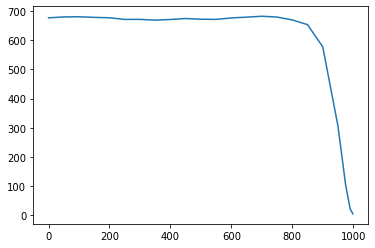

In [ ]:
xs = L.range(0,1000,50)+[975,990,999]
plt.plot(xs, [fid(samples[i]) for i in xs]);

In [ ]:
fid(xb)

1.291529932192475

## Inception

In [ ]:
from pytorch_fid.inception import InceptionV3

In [ ]:
a = tensor([1,2,3])
a.repeat((3,1))

tensor([[1, 2, 3],
        [1, 2, 3],
        [1, 2, 3]])

In [ ]:
class IncepWrap(nn.Module):
    def __init__(self):
        super().__init__()
        self.m = InceptionV3(resize_input=True)
    def forward(self, x): return self.m(x.repeat(1,3,1,1))[0]

In [ ]:
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus)

In [ ]:
fid = FID(IncepWrap(), dls, cbs=[DeviceCB()])

In [ ]:
%%time
fid(samples[-1])

CPU times: user 1min 45s, sys: 2.34 s, total: 1min 47s
Wall time: 4.42 s


47.324943177208525

In [ ]:
fid(xb)

25.480865263268072

## Export -

In [ ]:
import nbdev; nbdev.nbdev_export()